In [273]:
%load_ext autoreload
%autoreload 2

from flyvis import EnsembleView
import numpy as np
from cycler import cycler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
from flyvis.datasets.moving_bar import MovingEdge
from flyvis.analysis.moving_bar_responses import get_known_tuning_curves
from flyvis.analysis.moving_bar_responses import correlation_to_known_tuning_curves
from flyvis.analysis.flash_responses import flash_response_index, plot_fris
from flyvis.analysis.visualization import plt_utils
from flyvis.utils.color_utils import color_to_cmap
from flyvis.analysis.moving_bar_responses import plot_angular_tuning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
ensemble = EnsembleView(
    "flow/0000",
    best_checkpoint_fn_kwargs={
        "validation_subdir": "validation",
        "loss_file_name": "loss",
    },
)

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-07-18 18:52:54] ensemble:166 Loaded 50 networks.


In [295]:
T4__CELL_TYPE = "T4"
T5__CELL_TYPE = "T5"
CELL_TYPE = "T4c"
if CELL_TYPE.startswith(T4__CELL_TYPE):
    INTENSITY = 1
    INPUT_CELL_TYPES = ["Mi1", "Tm3", "Mi4", "Mi9", "CT1(M10)"]
    INPUT_CELL_TYPES__PLOT_RESPONSE = INPUT_CELL_TYPES
    CELL_TYPES__PLOT_REPONSE = sorted([CELL_TYPE] + INPUT_CELL_TYPES__PLOT_RESPONSE)
elif CELL_TYPE.startswith(T5__CELL_TYPE):
    assert CELL_TYPE.startswith(T5__CELL_TYPE)
    INTENSITY = 0
    INPUT_CELL_TYPES = ["Tm9", "Tm4", "Tm2", "Tm1", "CT1(Lo1)"]
    INPUT_CELL_TYPES__PLOT_RESPONSE = INPUT_CELL_TYPES
    CELL_TYPES__PLOT_REPONSE = sorted([CELL_TYPE] + INPUT_CELL_TYPES__PLOT_RESPONSE)
else:
    raise ValueError(f"Unaccounted for cell type {CELL_TYPE}")
gt_tuning = get_known_tuning_curves([CELL_TYPE], np.arange(0, 360, 90))
CT_PREFERRED_ANGLE = gt_tuning.angle[gt_tuning.argmax(dim="angle")].item()
print(f"Preferred angle of {CELL_TYPE} is {CT_PREFERRED_ANGLE}°.")

Preferred angle of T4c is 90°.


In [296]:
r = ensemble.moving_edge_responses()
norm = ensemble.responses_norm(rectified=True)
rmax = np.abs(r["responses"]).max(dim=("sample", "frame"))
# relative to the norm of the responses to naturalistic stimuli (used for averaging)
r["responses"] /= norm
# invariant to different magnitudes of responses, only to assess direction tuning
# r["responses"] /= rmax

/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/f5f7ab0e86eec6a74f7c7348ff271874/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/e4bde032c338b1cd29735e20d7295560/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/205d5ca11f565fb4051fa31c35611447/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/5c6c920ba6d8823e0ecde6bebde9038d/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/6dff21380290115f37d551ec4e3fb63c/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/005/__cache__/flyvis/analysis/stimulus_responses

In [297]:
cluster_indices = ensemble.cluster_indices(CELL_TYPE)
for clid, indices in cluster_indices.items():
    cluster_indices[clid] = indices[0:1]
    print(f"Cluster {clid} networks: {cluster_indices[clid]}")

/mnt/home/ckaneen/Software/flyvis-ckaraneen/.flyvis-env/lib64/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.1.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/mnt/home/ckaneen/Software/flyvis-ckaraneen/.flyvis-env/lib64/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.1.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
[2025-07-18 19:13:07] clustering:835 Loaded T4c embedding and clustering from /mnt/home/ckaneen/Software/flyvis-ckaraneen

Cluster 0 networks: [0]
Cluster 1 networks: [4]
Cluster 2 networks: [8]


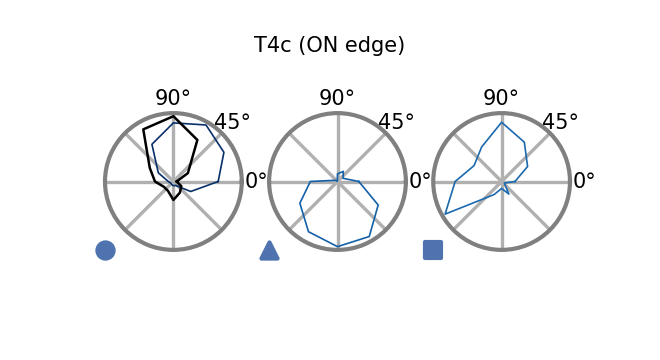

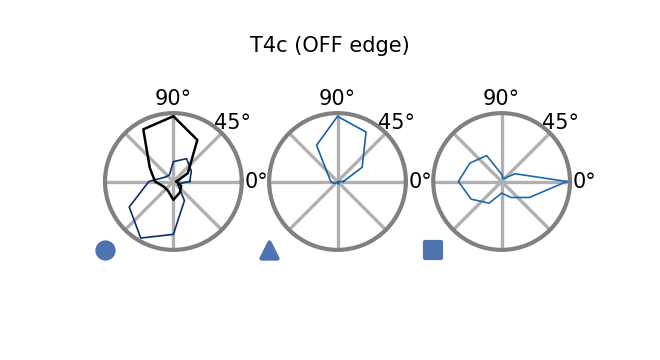

In [ ]:
colors = ensemble.task_error().colors
for intensity in [INTENSITY, 1 - INTENSITY]:
    edge = "ON" if intensity else "OFF"
    fig, axes = plt.subplots(
        1, len(cluster_indices), subplot_kw={"projection": "polar"}, figsize=[2, 1]
    )
    fig.suptitle(f"{CELL_TYPE} ({edge} edge)")
    for cluster_id, indices in cluster_indices.items():
        plot_angular_tuning(
            r.sel(network_id=indices),
            CELL_TYPE,
            intensity=intensity,
            linewidth=0.4,
            colors=colors[indices],
            zorder=ensemble.zorder()[indices],
            groundtruth=True if cluster_id == 0 else False,
            groundtruth_linewidth=0.6,
            average_models=True,
            fig=fig,
            ax=axes[cluster_id],
        )
        plt_utils.add_cluster_marker(
            fig, axes[cluster_id], marker=plt_utils.get_marker(cluster_id)
        )

In [299]:
r_new = ensemble.moving_edge_responses()
# invariant to different magnitudes of responses, only to assess direction tuning
r_new["responses"] /= np.abs(r_new["responses"]).max(dim=("sample", "frame"))

/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/f5f7ab0e86eec6a74f7c7348ff271874/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/e4bde032c338b1cd29735e20d7295560/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/205d5ca11f565fb4051fa31c35611447/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/5c6c920ba6d8823e0ecde6bebde9038d/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/6dff21380290115f37d551ec4e3fb63c/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/005/__cache__/flyvis/analysis/stimulus_responses

/tmp/ipykernel_1407879/2272324887.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_1407879/2272324887.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


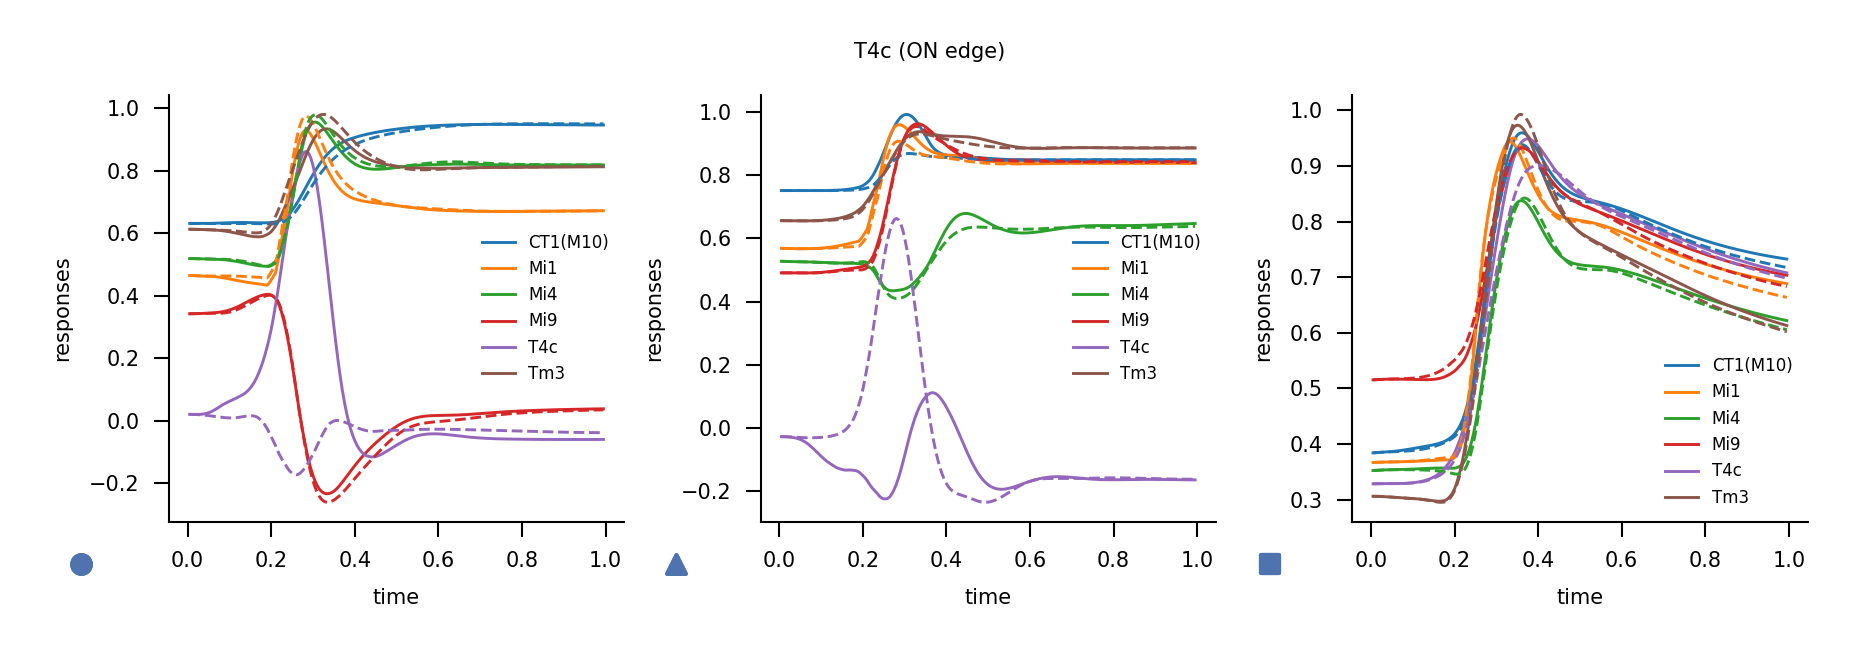

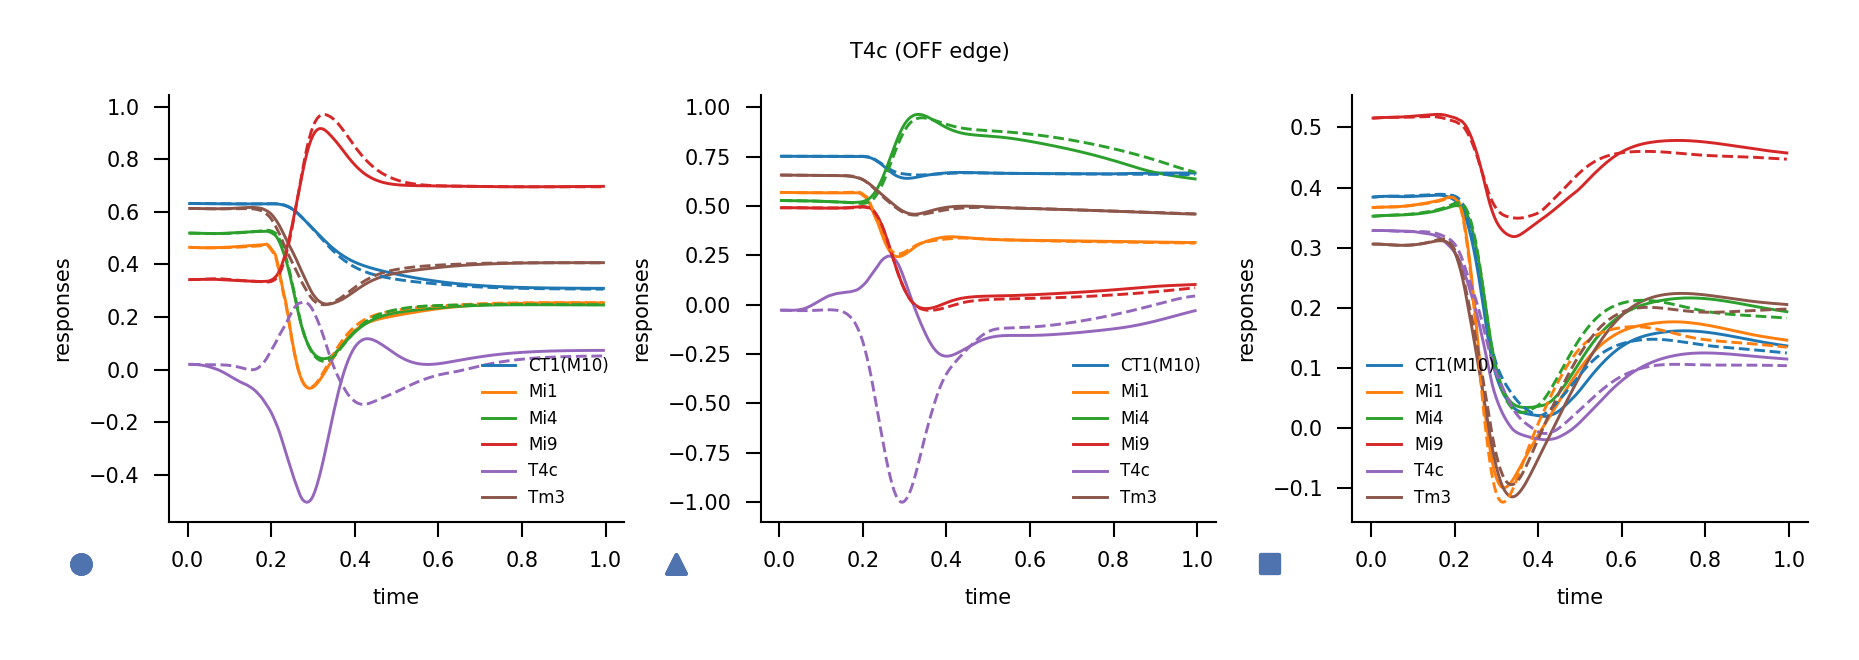

In [300]:
colors = {i: color for i, color in enumerate(mcolors.TABLEAU_COLORS.values())}
# Override the color cycle
plt.rcParams["axes.prop_cycle"] = cycler(
    color=list(colors.values())[: len(CELL_TYPES__PLOT_REPONSE)]
)
on_off_intensities = [INTENSITY, 1 - INTENSITY]
pd_nd_directions = [CT_PREFERRED_ANGLE, (CT_PREFERRED_ANGLE + 180) % 360]
pd_nd_linestyles = ["-", "--"]
for intensity in on_off_intensities:
    edge = "ON" if intensity else "OFF"
    fig, axes = plt.subplots(1, len(cluster_indices), figsize=(6, 2))
    fig.suptitle(f"{CELL_TYPE} ({edge} edge)")
    for d, lstyle in zip(pd_nd_directions, pd_nd_linestyles):
        for cluster_id, indices in cluster_indices.items():
            r_new["responses"].sel(network_id=indices).custom.where(
                cell_type=CELL_TYPES__PLOT_REPONSE,
                intensity=intensity,
                speed=19,
                angle=d,
                time=">0, <1.0",
            ).custom.plot_traces(
                x="time",
                plot_kwargs=dict(
                    ax=axes[cluster_id],
                    label=CELL_TYPES__PLOT_REPONSE if d == CT_PREFERRED_ANGLE else None,
                    linestyle=lstyle,
                    linewidth=.7,
                    color=None,
                ),
            )
            axes[cluster_id].legend(fontsize=4)
            plt_utils.add_cluster_marker(
                fig,
                axes[cluster_id],
                marker=plt_utils.get_marker(cluster_id),
                marker_size=20,
                x_offset=0.25 * (cluster_id - 1.7),
            )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
# Reset default color cycle
plt.rcParams["axes.prop_cycle"] = matplotlib.rcParamsDefault["axes.prop_cycle"]

/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/fa71065c78110742c90c1b014a42b75c/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/593ba4e16adc3fd2e4c0b42fa759a7b7/output.h5
/mnt/home/ckaneen/Software/flyvis-ckaraneen/data/results/flow/0000/008/__cache__/flyvis/analysis/stimulus_responses/compute_responses/89be806821a3e46d7e1964f6295d06db/output.h5


/tmp/ipykernel_1407879/2982155811.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


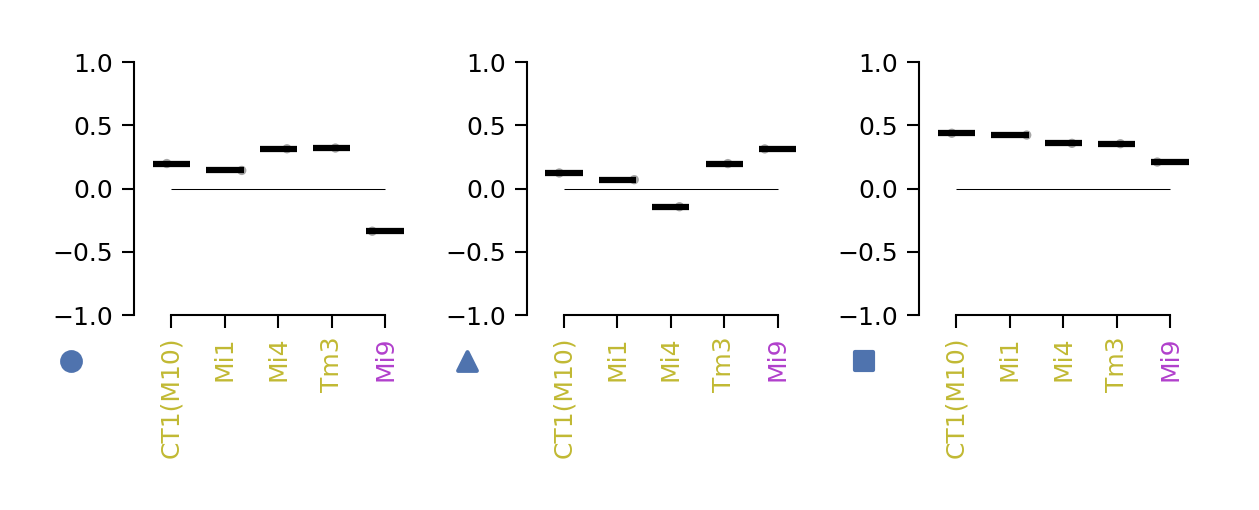

In [301]:
fig, axes = plt.subplots(1, len(cluster_indices), figsize=(4, 1.5))
for cluster_id, indices in cluster_indices.items():
    with ensemble.select_items(indices):
        ensemble.flash_response_index(
            cell_types=INPUT_CELL_TYPES,
            scatter_best=all(len(indices) > 1 for indices in cluster_indices.values()),
            fig=fig,
            ax=axes[cluster_id],
        )
    plt_utils.add_cluster_marker(
        fig,
        axes[cluster_id],
        marker=plt_utils.get_marker(cluster_id),
        marker_size=20,
        x_offset=0.25 * (cluster_id - 1.6),
        y_offset=0.2,
    )
fig.tight_layout()